In [9]:
# Imports
%matplotlib notebook
import random
import sys
import numpy as np
import scipy
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
# import seaborn as sns
import time
import csv
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
my_data_x = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_data_x.csv', delimiter=',')
my_data_y = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_data_y.csv', delimiter=',')
my_data_z = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_data_z.csv', delimiter=',')


# Load MagImage for deciding that where the data is and getting the width and Height of map
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data
gray_img = load_image('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/mag_map.png')
(g_height,g_width, channel_size)=gray_img.shape

mag_training_data_xy = []
mag_training_data_z = []
for i in range(g_height):
    for j in range(g_width):
        if gray_img[i][j][0]!=0.0:
            mag_training_data_xy.append([i*0.5, j*0.5]) # 0.5 means resolution when build magnetic map
            m_mag_vec = []
            m_mag_vec.append((my_data_x[i][j]+100))
            m_mag_vec.append((my_data_y[i][j]+100))
            m_mag_vec.append((my_data_z[i][j]+100))
            mag_training_data_z.append(m_mag_vec)
            
mag_training_data_xy = np.asarray(mag_training_data_xy)
mag_training_data_z = np.asarray(mag_training_data_z)
data_size = mag_training_data_z.shape[0]

In [4]:
def calculate_dis(current_pos, data_pos):
    return math.hypot((current_pos[0]-data_pos[0]), current_pos[1]-data_pos[1])

In [5]:
def my_gp(training_xy, training_z, test_xy):
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    start_time = time.time()
    gp.fit(training_xy, training_z)
    print("---Pred: %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    y_pred, sigma = gp.predict(test_xy, return_std=True)
    print("---Fit:  %s seconds ---" % (time.time() - start_time))
    y_pred = y_pred - 100
    return y_pred, sigma

def generate_test_data(training_xy):
    min_x = np.amin(training_xy[:,0])
    max_x = np.amax(training_xy[:,0])
    min_y = np.amin(training_xy[:,1])
    max_y = np.amax(training_xy[:,1])
    
    data_x_size = int(round((max_x-min_x)/0.5))
    data_y_size = int(round((max_y-min_y)/0.5))
    test_data_range_x =np.linspace(min_x, max_x, data_x_size)
    test_data_range_y =np.linspace(min_y, max_y, data_y_size)
    
    test_xy = np.zeros([data_x_size*data_y_size,2])
    for m in range(data_y_size):
        for n in range(data_x_size):
            test_xy[m*data_x_size+n][0] = test_data_range_x[n]
            test_xy[m*data_x_size+n][1] = test_data_range_y[m]
    return test_xy, data_x_size, data_y_size

def show_predic(test_xy, pred_z,m_axis):
    fig, ax = plt.subplots()
#     _min, _max = np.amin(pred_z), np.amax(pred_z)
    _min = -10
    _max = 4
    sc = plt.scatter(test_xy[:,0], test_xy[:,1], c=pred_z, cmap='rainbow', vmin = _min, vmax = _max)
    # plt.plot(mag_training_data_xy[:,0], mag_training_data_xy[:,1], 'ko')
    # for i in range(len(mag_training_data_z)):
    #     ax.annotate(np.round(mag_training_data_z[i],3), xy=(mag_training_data_xy[i][0],mag_training_data_xy[i][1]), color='black', 
    #             xytext=(5,5), textcoords="offset points")
    file_path = "/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/"
    filename = file_path+"scikit_GP_result_"+m_axis
    plt.colorbar()
    plt.savefig(filename)
    plt.show()

In [6]:
test_xy, data_x_size, data_y_size = generate_test_data(mag_training_data_xy)

mag_x_pred, mag_x_sigma = my_gp(mag_training_data_xy, mag_training_data_z[:,0], test_xy)
mag_y_pred, mag_y_sigma = my_gp(mag_training_data_xy, mag_training_data_z[:,1], test_xy)
mag_z_pred, mag_z_sigma = my_gp(mag_training_data_xy, mag_training_data_z[:,2], test_xy)

my_draw_test_data_x = test_xy[:,0].reshape(data_x_size*data_y_size,1)
my_draw_test_data_y = test_xy[:,1].reshape(data_x_size*data_y_size,1)
my_test_predict_zx = mag_x_pred.reshape(data_x_size*data_y_size,1)
my_test_predict_zy = mag_y_pred.reshape(data_x_size*data_y_size,1)
my_test_predict_zz = mag_z_pred.reshape(data_x_size*data_y_size,1)

# # fig, ax = plt.subplots()
# # _min, _max = np.amin(mag_training_data_z), np.amax(mag_training_data_z)
# # sc = plt.scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zz, cmap='rainbow', vmin = _min, vmax = _max)
# # plt.colorbar()



---Pred: 11.911906957626343 seconds ---
---Fit:  0.26920294761657715 seconds ---
---Pred: 5.796087741851807 seconds ---
---Fit:  0.27559399604797363 seconds ---
---Pred: 6.262662649154663 seconds ---
---Fit:  0.27176332473754883 seconds ---


<IPython.core.display.Javascript object>


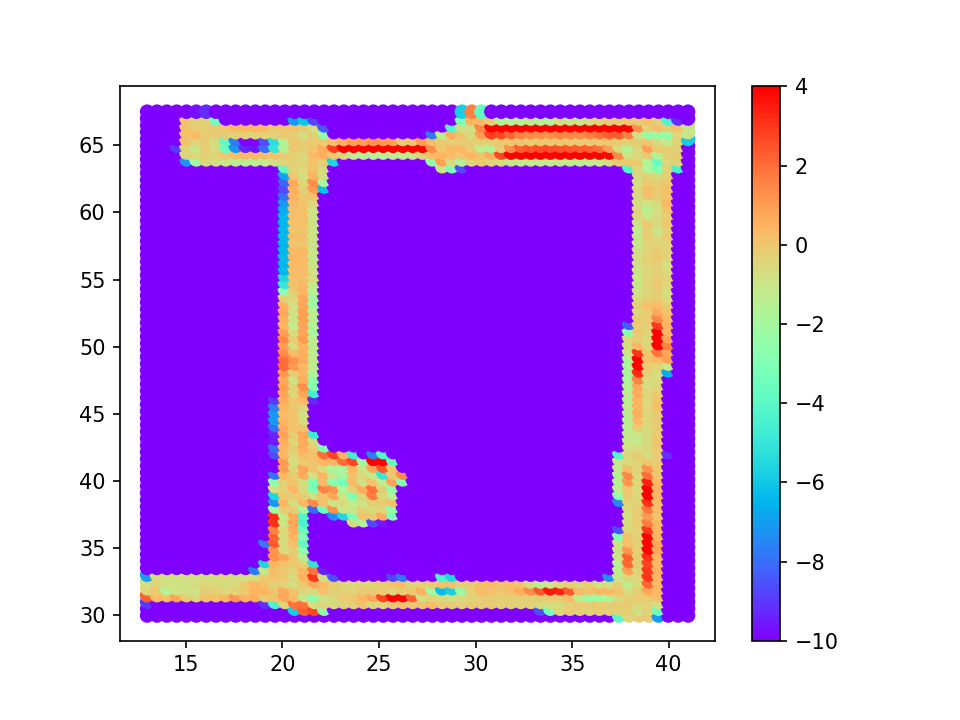

<IPython.core.display.Javascript object>


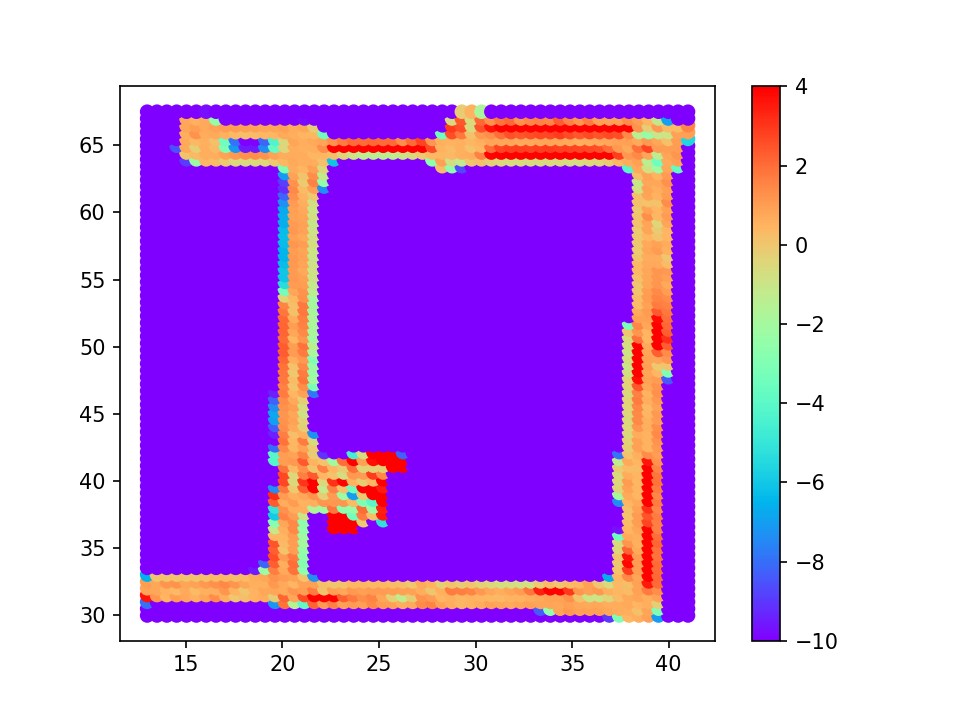

<IPython.core.display.Javascript object>


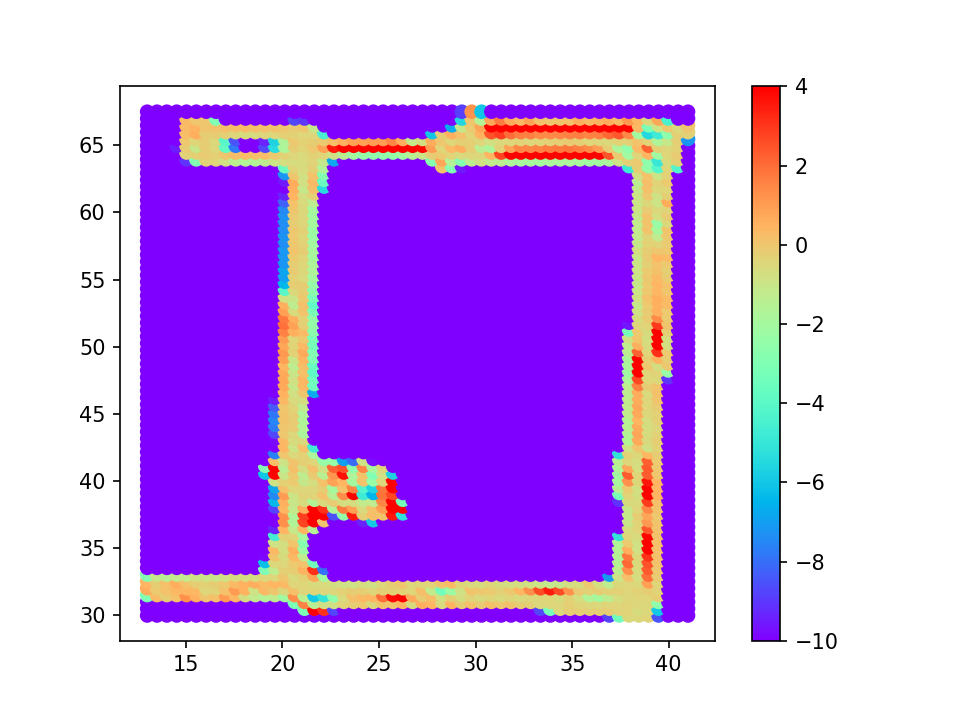

In [7]:
# f, axes = plt.subplots(nrows = 1, ncols = 3, sharex=True, sharey = True)
# _min, _max = np.amin(my_test_predict_zx), np.amax(my_test_predict_zx)
# sc = axes[0].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zx, cmap='rainbow', vmin = _min, vmax = _max)
# _min, _max = np.amin(my_test_predict_zy), np.amax(my_test_predict_zy)
# axes[1].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zy, cmap='rainbow', vmin = _min, vmax = _max)
# _min, _max = np.amin(my_test_predict_zz), np.amax(my_test_predict_zz)
# axes[2].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zz, cmap='rainbow', vmin = _min, vmax = _max)
# f.colorbar(sc)
show_predic(test_xy, mag_x_pred, 'x')
show_predic(test_xy, mag_y_pred, 'y')
show_predic(test_xy, mag_z_pred, 'z')

In [53]:
mag_x_pred = mag_x_pred.reshape(batch_data_x_size,batch_data_y_size)
mag_y_pred = mag_y_pred.reshape(batch_data_x_size,batch_data_y_size)
mag_z_pred = mag_z_pred.reshape(batch_data_x_size,batch_data_y_size)
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_x.csv", mag_x_pred, delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_y.csv", mag_y_pred, delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_z.csv", mag_z_pred, delimiter=",")


<IPython.core.display.Javascript object>


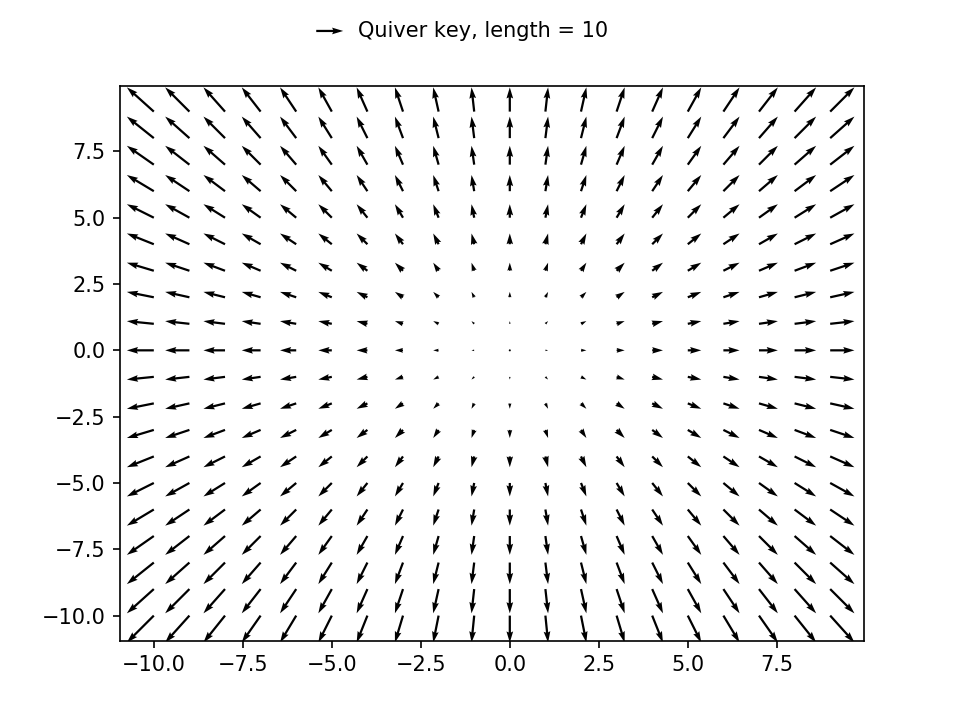

In [10]:
X = np.arange(-10, 10, 1)
Y = np.arange(-10, 10, 1)
U, V = np.meshgrid(X, Y)

fig, ax = plt.subplots()
q = ax.quiver(X, Y, U, V)
ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Quiver key, length = 10', labelpos='E')

plt.show()

In [12]:
U

array([[-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9],
       [-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9],
       [-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9],
       [-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9],
       [-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9],
       [-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9],
       [-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9],
       [-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9],
       [-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,  